<br>
<p>
    <img src="https://i.imgur.com/4HDrq2b.png" alt="Drawing" style="width: 700px;">
</p>
<br>
<center>
    <h1 style="font-size:36px;">Analysing Predictors of Reddit Comment Score</h1>
    <br>
    <h3>By: Nathaniel Lin and David Koh</h3>
    <h4>University of Maryland, College Park, CMSC320<h4>
    <hr>
    <h2>Introduction</h2>
</center>
<p>
    For those who are not familiar with the site, reddit.com is a link-based forum that allows any user to post content to a multitude of different topic boards called "subreddits". The site was originally established in 2005 but ithas since been gaining traction and today sits at the 7th most popular website by user traffic. Reddit also allows users to comment as a reply to a post or to another comment. The aspect of reddit that distinguises it from most other internet forums is its voting system. Posts and comments can both be voted on one time by each user and this rating determines how visible a post or comment is to other users. This incentivies users to post content that they believe will recieve a high score. 
</p>
<p>
    In this project we will be analysing what factors contribute to the score that any given comment may receive. We will be looking at the relationships between the score and the text contained in the comment as well as the context surrounding the comment and the board to which it was posted in order to determine what other variables may impact a comment's score.
    
<font color="red"><b>WARNING: Because we are analysing a dataset of the most negatively reviewed comments and subreddits, some of the comments or subreddit names may contain strong language or particularly offensive subjects. Be cautious when reading through the code's output.</b></font>
</p>
<hr>
<center><h2>Formatting and Tidying the Data</h2></center>
<br>
<p>
    The dataset we will be utilizing to conduct our analysis was found through Kaggle and is titled "<a href="https://www.kaggle.com/ehallmar/reddit-comment-score-prediction">Reddit Comment Score Prediction</a>". The data from the site consists two .csv files, one of these files contains the top 2,000,000 highest rated comments and the other has the 2,000,000 lowest rated comments. In addition to the comment text and score, the author has also included the id of the subreddit the comment was posted to, the author of the comment, the parent comment(the comment the poster replied to), the parent comment's score, and a controversiality flag. Before we were able to load these files into the repository, each file was trimmed by a factor of ten. There were two reasons for this: 1) Git is not able to upload files larger than 100MB. 2) Working with any more than 200,000 entries causes many operations to run too slowly. The least significant 90% of entries were dropped such that the positive list contains the highest rated 200k comments and the negative list contains the lowest rated 200k comments. These files are then loaded into pandas dataframes.
</p>

In [225]:
import pandas
import numpy as np
#pip install praw
import praw
#pip install nltk
import nltk


positive = pandas.read_csv("./db/comments_positive_reduced.csv", dtype={"score": 'object', "ups": 'object', "controversiality": 'object'})
negative = pandas.read_csv("./db/comments_negative_reduced.csv", dtype={"score": 'object', "ups": 'object', "controversiality": 'object'})
positive.head(5)

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality
0,c092j8m,t1_c092gss,t5_2qh2p,t3_8eyy3,This isn't Twitter: try to comment on the arti...,9582,9582,nraustinii,0,t3_8eyy3,Fucking faggot.,-7526.0,-7526.0,Glorificus,0.0
1,c4imcva,t1_c4im948,t5_2qh1i,t3_t0ynr,"Well, it is exactly what it sounds like. It's ...",9531,9531,Lynfect,0,t3_t0ynr,"Elaborate on this cum box, please.",3841.0,3841.0,eeeeevil,0.0
2,c0s4nfi,t1_c0s4lje,t5_2qh1i,t3_cf1n2,"In soviet Russia, bomb disarms you!",8545,8545,CapnScumbone,0,t3_cf1n2,"I don't live in Russia anymore, and I will not...",621.0,621.0,shady8x,0.0
3,c4ini33,t1_c4incln,t5_2qh1i,t3_t0ynr,"""runin for senitur! #YOLO!""",7430,7430,[deleted],0,t3_t0ynr,This just made me realize that future presiden...,4651.0,4651.0,drspg99,0.0
4,c4imgel,t1_c4ima2e,t5_2qh1i,t3_t0ynr,You step motherfucker.,7173,7173,jbg89,0,t3_t0ynr,I have sex with my step mom when my dad isn't ...,4251.0,4251.0,audir8,0.0


<br>
Here we can see the format of the data. We have also imported some of the necessary libraries. The first two if these imports are the familiar pandas and numpy libraries, the next two require an installation and are specific to this project. <a href="https://praw.readthedocs.io/en/latest/index.html">Praw</a> allows us to use Reddit objects to look up posts, users, and subreddits and their respective attributes. <a href="https://www.nltk.org/">NLTK</a> will simplify the process of breaking up the comment text into words and determining what words are useful and which are not. Below we utilize Praw to create a reddit instance (Yes, my reddit username is /u/getpwnedx. -Nathan).

In [2]:
reddit = praw.Reddit(client_id='**************',
                     client_secret='***************************',
                     user_agent='firefox:commentscorepredictor:v1.0 (by /u/getpwnedx)')

print(reddit.read_only)
list(reddit.info(['t5_2sokd']))

True


[Subreddit(display_name='explainlikeimfive')]

<br>
The first necessary step to modifying this data was to extract the actual subreddit names from the provided IDs. This is when we noticed that the data had not been entirely parsed correctly. It is likely that the author of this dataset used a webscraper to obtain all this information and so there were a few instances where a single comment had been duplicated across multiple entries causing each column to fill up with improper data types. This caused a problem when attempting to extract the name of a subreddit from an id that does not correspond to any actual subreddit. To fix this problem, we replace the subreddit name with UNKNOWN_SUBREDDIT if the id could not be parsed. Additionally, during this process we found that using the praw api to look up each id individually was very slow, too slow to iterate over the entire table and find each corresponding name. To circumvent this, after an id was looked up once, it was placed into a map. The map was then used to look up the names instead of calling the api. This process was repeated for both positive and negative datasets

In [226]:
positive["subreddit_name"] = ""

#
subtoid = {None: "UNKNOWN_SUBREDDIT", np.nan: "UNKNOWN_SUBREDDIT"}

for idx, row in positive.iterrows():
    #Checking if subreddit id already is in dict
    if subtoid.get(row["subreddit_id"]) == None:
        
        #Get subreddit from PRAW api
        subreddit = list(reddit.info([row["subreddit_id"]]))
        
        #If subreddit exists, add to map
        if len(subreddit) >= 1:
            subtoid[row["subreddit_id"]] = list(reddit.info([row["subreddit_id"]]))[0].display_name
        else:
            positive.at[idx, "subreddit_name"] = "UNKNOWN_SUBREDDIT"
            continue
        
    #Write the subreddit name into the dataframe
    positive.at[idx, "subreddit_name"] = subtoid[row["subreddit_id"]]
    
negative["subreddit_name"] = ""

subtoid.clear()
subtoid = {None: "UNKNOWN_SUBREDDIT", np.nan: "UNKNOWN_SUBREDDIT"}

for idx, row in negative.iterrows():
    if subtoid.get(row["subreddit_id"]) == None:
        subreddit = list(reddit.info([row["subreddit_id"]]))
        if len(subreddit) >= 1:
            subtoid[row["subreddit_id"]] = list(reddit.info([row["subreddit_id"]]))[0].display_name
        else:
            negative.at[idx, "subreddit_name"] = "UNKNOWN_SUBREDDIT"
            continue
        
    negative.at[idx, "subreddit_name"] = subtoid[row["subreddit_id"]]
    
negative.head(5)

,id,parent_id,subreddit_id,link_id,text,score,ups,author,controversiality,parent_link_id,parent_text,parent_score,parent_ups,parent_author,parent_controversiality,subreddit_name
0,c0a2d2p,t1_c0a2cn1,t5_1a8ah,t3_8pr4w,"Na, not really. \n\nI just hate islam and ever...",-2946,-2946,b34nz,0,t3_8pr4w,What goes through the heads of you people? Is...,459,459,[deleted],0,obama
1,c6okok8,t1_c6oaywb,t5_2s8e9,t3_11otij,lol you're some ugly ass white dude,-2724,-2724,letmetellyouhowitis,0,t3_11otij,This is worth noting.\n\nThankfully I don't.,72,72,flowen65,0,frugalmalefashion
2,c3nlalf,t1_c3nijr7,t5_2qzb6,t3_p9a1v,"First of off, its not true, and second off, I ...",-2132,-2132,iamwoodyharrelson,0,t3_p9a1v,I swear this is *(allegedly)* a true story. I...,4028,4028,AndyRooney,0,IAmA
3,c10nh8q,t1_c10nc34,t5_6,t3_djasj,Who made you reddit police? I will submit what...,-2117,-2117,JimmyJamesincorp,0,t3_djasj,I was on my way over here to bitch and moan ab...,1214,1214,SloaneRanger,0,reddit.com
4,c3nlufk,t1_c3nlcob,t5_2qzb6,t3_p9a1v,We gotta be...i consider my time valuable.,-1962,-1962,iamwoodyharrelson,0,t3_p9a1v,Should change this AMA to AMAAR (Ask Me Anythi...,1405,1405,bersh,0,IAmA


<br>
Here we do the aforementioned dropping of the rows that contained invalid values. Each other row contains a non-NaN/null value.

In [5]:
valid_pos = positive.dropna()
valid_neg = negative.dropna()

<br>
We then drop all of the column values from the data that are not relevant to our analysis. We considered using the "controversiality" flag as a score predictor but found that only a very small proportion of the comments were marked as controversial and so we could not draw any significant conclusions from it.

In [6]:
valid_pos = valid_pos.drop(columns=["subreddit_id", "link_id", "ups", "controversiality", "parent_link_id", "parent_ups", "parent_controversiality"])
valid_neg = valid_neg.drop(columns=["subreddit_id", "link_id", "ups", "controversiality", "parent_link_id", "parent_ups", "parent_controversiality"])

<br>
To prevent the need for repeating the slow process of re-acquiring the labels for each subreddit each time the code is run, we exported the appended data to json format. Originally, this export was to csv but we found that when reloading the file into a dataframe, many rows had been duplicated. To prevent this ambuitity when exporting, we exported the data as json. However, json is a heavier data format and so this required that we truncate another 20k of our lowest scoring comments to stay within the 100MB file limit.

In [11]:
#Dropping last 20k entries due to git size limitations
valid_pos.iloc[:180000].to_json(path_or_buf='positive_subs.json')
valid_neg.iloc[:180000].to_json(path_or_buf='negative_subs.json')

In [197]:
#Reloading the data from json files into dataframes
negjson = pandas.read_json("./db/negative_subs.json")
posjson = pandas.read_json("./db/positive_subs.json")

<br>
In order to determine if the length of a comment impacted the average score, we added a column containing the length of the parent and child comment for both tables.

In [228]:
for idx, row in posjson.iterrows():
    posjson.at[idx, "text_len"] = len(row["text"].split())
    posjson.at[idx, "parent_text_len"] = len(row["parent_text"].split())
    
for idx, row in negjson.iterrows():
    negjson.at[idx, "text_len"] = len(row["text"].split())
    negjson.at[idx, "parent_text_len"] = len(row["parent_text"].split())
    
posjson.head(5)

,id,parent_id,text,score,author,parent_text,parent_score,parent_author,subreddit_name,text_len,parent_text_len,abs_parent_score
0,c092j8m,t1_c092gss,This isn't Twitter: try to comment on the arti...,9582,nraustinii,Fucking faggot.,-7526,Glorificus,atheism,14.0,2.0,7526
1,c4imcva,t1_c4im948,"Well, it is exactly what it sounds like. It's ...",9531,Lynfect,"Elaborate on this cum box, please.",3841,eeeeevil,AskReddit,329.0,6.0,3841
2,c0s4nfi,t1_c0s4lje,"In soviet Russia, bomb disarms you!",8545,CapnScumbone,"I don't live in Russia anymore, and I will not...",621,shady8x,AskReddit,6.0,57.0,621
3,c4ini33,t1_c4incln,"""runin for senitur! #YOLO!""",7430,[deleted],This just made me realize that future presiden...,4651,drspg99,AskReddit,4.0,16.0,4651
4,c4imgel,t1_c4ima2e,You step motherfucker.,7173,jbg89,I have sex with my step mom when my dad isn't ...,4251,audir8,AskReddit,3.0,26.0,4251


<hr>
<img src="https://statistics.laerd.com/statistical-guides/img/pc/pearson-2-small.png" alt="Drawing" style="width: 400px;">
<br>
<center><h2>Exploratory Data Analysis</h2></center>
<br>
<h3>Parent score versus child score</h3>
<p>
    The first possible correlation we wanted to explore was the connection between the score of the parent comment and the score in question. Specifically, we wanted to see if there was a trend in the types of parent comments that produce extreme comment scores.

(-200, 200)

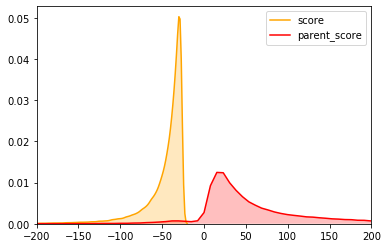

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.kdeplot(negjson["score"], shade=True, bw=2, color="orange", gridsize=2000)
sns.kdeplot(negjson["parent_score"], shade=True, bw=2, color="red", gridsize=2000)
plt.xlim(-200, 200)

<h4>Distribution of score and parent score for negative comments</h4>
<br>
The above distribution plot shows how the parent scores for the 180k most negative comments were distributed. As expcted, the negative comments tend to increase in frequency the closer they are to a score of 0. This is not entirely surprising as reddit has a feature that will hide comments with a score of -4 or below and so it is much less common for these comments to receive many additional downvotes. Much more surprisingly, the parents of these comments seem to be overwhelmingly positive. This seems to suggest that most highly negative comments are badly recieved responses to more positive comments.

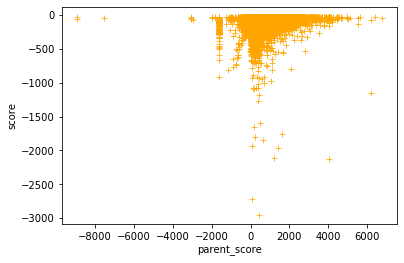

In [200]:
sns.scatterplot(x=negjson["parent_score"], y=negjson["score"], marker="+", color = "orange")

<h4>Scatter plot of score and parent score for negative comments</h4>
<br>
While most of these points are too close to gather much information, we can see that the majority of scores are clustered towards the center where even the most extremely low rated comments are responses to comments that may only have a thousand or fewer points.

(-300, 500)

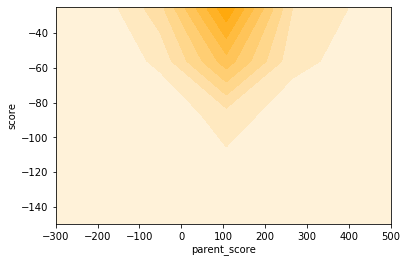

In [201]:
sns.kdeplot(negjson["parent_score"], negjson["score"], bw=10, shade=True, color = "orange")
plt.ylim(-150, -25)
plt.xlim(-300, 500)

<h4>2D density plot of score and parent score for negative comments</h4>
<br>
This kdeplot shows a much more zoomed-in view of the previous scatter plot. From this plot, we can see that the mean score is around -30 and the corresponding parent score is a bit above 100. Outward from this point, entries seem to get less and less common, indicating this is the most frequent score for our set of negative comments. Based on these charts, it seems that there is very little relationship between a negative comment's parent score and the child's score.

(-500, 4000)

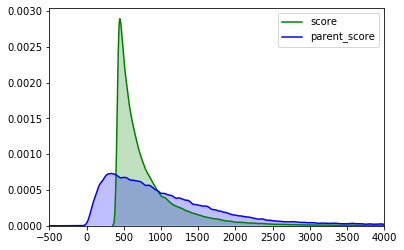

In [203]:
sns.kdeplot(posjson["score"], shade=True, bw=20, color="green", gridsize=2000)
sns.kdeplot(posjson["parent_score"], shade=True, bw=20, color="blue", gridsize=2000)
plt.xlim(-500,4000)

<h4>Distribution of score and parent score for positive comments</h4>
<br>
Compared to the negative distribution plot, we can see a much more clear relationship between the score of a parent comment and its positive child comment. While the positive comments tend to cluster towards the lower values, the parent comments for those scores are much more evenly distributed across the score range and are often times scored lower than the child comment.

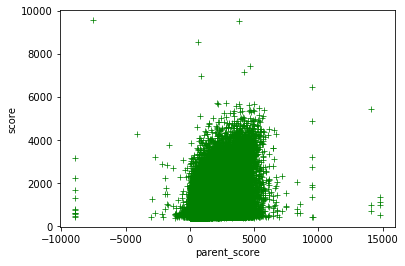

In [204]:
sns.scatterplot(x=posjson["parent_score"], y=posjson["score"], marker="+", color = "green")

<h4>Scatter plot of score and parent score for positive comments</h4>
<br>
Much like the previous scatterplot, most of the points are clustered too close together to gather any real information from this plot, but it is immediately noticible that the spread of positive comment scores for both the child and parent comment are mich wider with scores as high as 5000 still recieving significant representation.

(-200, 2000)

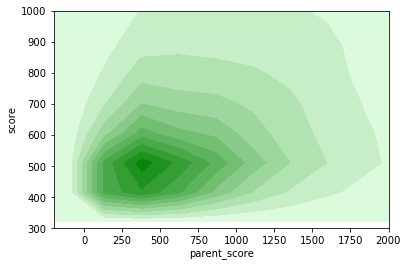

In [205]:
sns.kdeplot(posjson["parent_score"], posjson["score"], shade=True, color="green")
plt.ylim(300, 1000)
plt.xlim(-200, 2000)

<h4>2D density plot of score and parent score for positive comments</h4>
<br>
Looking at a closer view of the scatter plot once again, we can see that the highest density of positive comments recieved an average score of around 500 with a parent score of about 350. But unlike the negative density plot, the observations are noticably skewed to the right. Instead of the previous uniform distribution of parent scores across negative comments, it seems that positively scored parent comments have a relationship with positively scored child comments.
<hr>
<h3>Comment score versus length</h3>
<br>
With the information that we added to our dataset in the data formatting section, it is possible to test if there is a connection between the length of a comment and the score that comment would be expected to receive.

In [202]:
#Adding columns for absolute score values
negjson["abs_score"] = abs(negjson["score"])
negjson["abs_parent_score"] = abs(negjson["parent_score"])
negjson.corr()

,score,parent_score,text_len,parent_text_len,abs_score,abs_parent_score
score,1.000000,-0.098931,-0.016414,0.011744,-1.000000,-0.138251
parent_score,-0.098931,1.000000,0.009572,0.118021,0.098931,0.911137
text_len,-0.016414,0.009572,1.000000,0.146414,0.016414,0.004492
parent_text_len,0.011744,0.118021,0.146414,1.000000,-0.011744,0.123392
abs_score,-1.000000,0.098931,0.016414,-0.011744,1.000000,0.138251
abs_parent_score,-0.138251,0.911137,0.004492,0.123392,0.138251,1.000000


<h4>Negative correlation coefficents</h4>

Here we are analysing the pearson correlation (r-value) coefficent for each of our quantitative variables. A negative value indicates that a positve change in one value results in a negative change in the other while a positive value indicates that if one value increases the other generally will also increase. The value is on a scale of -1 to 1 where more positive and negative values indicate a stronger correlation. Through this table we can see that our earlier suspicion that parent score and child score were unrelated was mostly correct (r=-0.0989) as there is no meaningful relationship between these values. We also checked the child score against the absolute parent score. This value would be high if a highly positive OR negative parent score would generally produce a highly negative comment but this relationship also turned out to be of negligible importance. (r=-0.1383)

We can also see that the text length does not have a meaningful impact on the expected score of a comment (r < abs(.1)). A similar statement holds true for parent text length and parent comment score but with a slightly higher correlation coefficent.

In [206]:
posjson["abs_parent_score"] = abs(posjson["parent_score"])
posjson.corr()

,score,parent_score,text_len,parent_text_len,abs_parent_score
score,1.000000,0.493862,0.025013,0.025240,0.498738
parent_score,0.493862,1.000000,-0.023286,0.148703,0.985190
text_len,0.025013,-0.023286,1.000000,0.132724,-0.021691
parent_text_len,0.025240,0.148703,0.132724,1.000000,0.153932
abs_parent_score,0.498738,0.985190,-0.021691,0.153932,1.000000


<h4>Positive correlation coefficents</h4>

Here we have the same correlation matrix reproduced for the positive entries. Length-wise, many of our findings from the previous matrix also hold true. The length of a positive comment does not seem to have an impact on the score of the comment. However, we are again able to confirm our findings from the distribution plots as we can see that there is a significant positive correlation between the score of a parent comment and that of a child (r=0.4938). We did not include the absolute score on this matrix since all scores in this list are guarenteed to be positive.

<hr>
<h3>Frequency of comments per subreddit</h3>

Now we would like to look at which of the subredits have the most negatively and positively scored comments. We will start by counting the number of comments in each table for each subreddit.

In [216]:
pos_sub_freq = posjson.groupby("subreddit_name").count().sort_values(by="id", ascending=False)
pos_sub_freq = pos_sub_freq.drop(columns=["id", "parent_id", "text", "author", "parent_text", "parent_score", "parent_author", "abs_parent_score", "text_len", "parent_text_len"])

neg_sub_freq = negjson.groupby("subreddit_name").count().sort_values(by="id", ascending=False)
neg_sub_freq = neg_sub_freq.drop(columns=["id", "parent_id", "text", "author", "parent_text", "parent_score", "parent_author", "abs_parent_score", "text_len", "parent_text_len", "abs_score"])
neg_sub_freq.head(10)

,score
subreddit_name,
funny,15198
AskReddit,13125
pics,11669
gaming,8887
WTF,7949
politics,5178
IAmA,4940
videos,4558
todayilearned,4092


<br>
Here we can see the top ten most frequently appearing subreddits from the table of negative comments. However, this table alone does not give us much insight as to how negative these communities are as this list is mostly comprised of the most popular subreddits. In order to get a per-capita estimate of how often negative comments appear in these communites, it is necessary to know the subscriber count for each board.

The code below looks up the subscriber count of each unique subreddit using the previously created praw reddit instance. Some of the comments that existed in the dataset came from communities that have since disbanded or been banned by the reddit administrators. To circumvent this, we catch a praw exception if the subreddit does not exist and add these subreddits to a "banned" list. Be warned, some of the banned subreddit names are particularly shocking.

In [218]:
pos_sub_freq["subscribers"] = np.nan

for idx, row in pos_sub_freq.iterrows():
    try:
        t_subs = reddit.subreddit(idx).subscribers     
    except:
        t_subs = 0
    finally:
        pos_sub_freq.at[idx, "subscribers"] = int(t_subs)

neg_sub_freq["subscribers"] = np.nan
banned_or_removed = []

for idx, row in neg_sub_freq.iterrows():
    try:
        t_subs = reddit.subreddit(idx).subscribers     
    except:
        banned_or_removed.append(idx)
        t_subs = 0
    finally:
        neg_sub_freq.at[idx, "subscribers"] = int(t_subs)
        
print("could not look up subscriber count for banned/private/quarantined subreddits: ")
print(banned_or_removed)
neg_sub_freq.head(10)

could not look up subscriber count for banned/private/quarantined subreddits: 
['fatpeoplehate', 'watchpeopledie', 'CringeAnarchy', 'TheRedPill', 'Top_Comment_Judge', 'toosoon', 'CoonTown', 'StandUpComedians', 'metaredditcancer', 'Gore', 'incest', 'CandidFashionPolice', 'neckbeardstories', 'IDrawMuhammad', 'DateRape', 'DarkNetMarkets', 'opieandanthony', 'HealthProject', 'BlackFathers', 'video', 'starlets', 'doppelbangher', 'AmateurArchives', 'AngieVaronaLegal', '8chan', 'A858DE45F56D9BC9', 'theoffice', 'PicsOfDeadKids', 'TruePPD', 'myevilplan', 'TalesofFatHate']


,score,subscribers
subreddit_name,,
funny,15198,27573722.0
AskReddit,13125,25556126.0
pics,11669,23367380.0
gaming,8887,24415999.0
WTF,7949,5983877.0
politics,5178,5592959.0
IAmA,4940,19613099.0
videos,4558,21724038.0
todayilearned,4092,21874066.0


<br>
Here we can see the resulting table with appended subscriber count. Taking this a step further, we will divide the subscribers by the number of posts in each table to produce two new tables.

In [219]:
pos_sub_freq["subs_per_comment"] = pos_sub_freq["subscribers"] / pos_sub_freq["score"]
top_pos = pos_sub_freq[pos_sub_freq["subscribers"] > 5000].sort_values(by="subs_per_comment")

neg_sub_freq["subs_per_comment"] = neg_sub_freq["subscribers"] / neg_sub_freq["score"]
top_neg = neg_sub_freq[neg_sub_freq["subscribers"] > 5000].sort_values(by="subs_per_comment")
top_pos.head(10)

,score,subscribers,subs_per_comment
subreddit_name,,,
AskReddit,92431,25556126.0,276.488689
reddit.com,1742,829116.0,475.956372
WTF,7075,5983877.0,845.777668
Shitty_Watercolour,14,13855.0,989.642857
IAmA,14521,19613099.0,1350.671372
nfl,1215,1697202.0,1396.874074
Denver,68,116245.0,1709.485294
pics,11844,23367379.0,1972.929669
promos,6,11993.0,1998.833333


<br>
Finally, we can now see the per-user comment frequencies. This score indicates how many subscribers there are to the subreddit per each positive or negative comment. In other words, a lower value indicates a higher per-capita density of positive or negative comments. We have also chosen to prune the subreddits with extremely low subscriber counts as these tend to be outliars that benefit off of one or two unusually successful posts and heavily skew the data. We have placed the data for the 10 most extreme entries into graphs below. It should be noted that the subreddits with the highest subscriptions per comment are well into the 100,000s and sometimes millions of subscriptions per extreme comment. Such subreddits could be considered "very neutral".

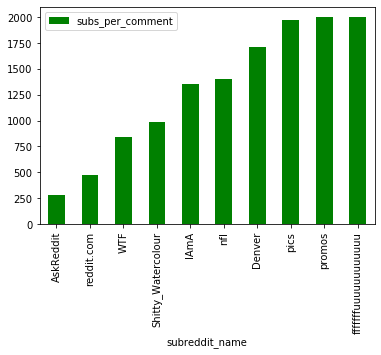

In [220]:
top_pos.head(10).plot.bar(y="subs_per_comment", color="green")

<h4>Positive subreddits</h4>
<br>
From this graph, we can see that /r/AskReddit is the most positive scoring subreddit with a single top-200k comment per every 276 users. Comparitively, the subreddit in the 10th slot only receives a top 200k comment once per 2,000 users. This is a very significant difference and goes to show how many comments in the largest subreddits tend to recieve very high scores. Posting in any of these subreddits (with the exception of /r/fffffffuuuuuuuuuuuu) would likely boost your chances of being given a high comment score. 

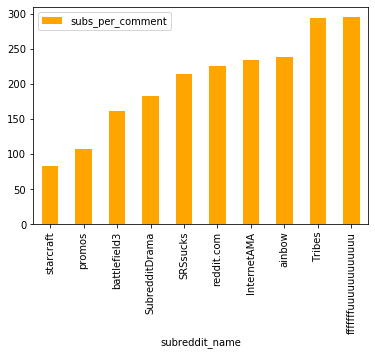

In [222]:
#NOTE y axis range
top_neg.head(10).plot.bar(y="subs_per_comment", color="orange")

<h4>Negative subreddits</h4>
<br>
This graph is the opposite of the previous graph where these subreddits hold the most toxic comment sections with the highest rate of low scoring comments. What is particularly interesting is that the range and lower minimum of subscribers per comment in this section is significantly lower than in the previous graph. This means that it is likely easier to receive an exceedingly negative score from any of these subreddits than it is to receive a significantly positive score from any of the previous subreddits. Another noteworthy trend from this graph is that 3/10 of these subreddits are related to video games (we'll leave someone else to investigate this one) and that /r/fffffffuuuuuuuuuuuu appeared as 10th in both lists. This may indicate that the subreddit is highly polarizing. 

Based on this information as a whole, it is clear that some subreddits offer a significant advantage over others when it comes to how a comment will be scored. However, it is difficult to quantify how big of an advantage any given subreddit may give for any particular comment. This is a topic that could likely be explored in the future of this project.
<hr>

<img src="https://static.packt-cdn.com/products/9781782167853/graphics/7853OS_06_01.jpg" alt="Drawing" style="width: 700px;">
<h2>
    <center>
        Words as Predictors for Positivity or Negativity in Comments
    </center>
</h2>
<p>
This segment will analyze the frequency of words that appear in the most positively and negatively scored comments from Reddit. The two nltk package downloads are required to tag individual words to their part of speech. This allows us to filter the words we do not believe are relevant to a post's popularity. The hypothesis being tested is whether there exists a relationship or effect of the semantics of words and the resulting positivity or negativity score a message receives. This serves to establish if certain key words exist that would tend to make an audience like or dislike comments disproportionately more than other words. Likewise, the experiment will serve as an algorithm that could potentially score words based on this positivity or negativity rating.
</p>

In [37]:
import pandas as pd
import pandas
import numpy as np
import praw
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import gc
from sklearn import preprocessing

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

<h3><center>Setup</center></h3>
The word maps will contain every instance of a valid word within the comment texts. The pos_map is a list of parts of speech that will be included in the filtering for our word table.

List with examples
<ul>
  <li>JJ adjective 'big'
</li>
  <li>JJR adjective, comparative 'bigger'
</li>
  <li>JJS adjective, superlative 'biggest'
</li>
  <li>NN noun, singular 'desk'
</li>
  <li>NNS noun plural 'desks'
</li>
  <li>NNP proper noun, singular 'Harrison'
</li>
   <li>NNPS proper noun, plural 'Americans'
</li>
  <li>RB adverb very, silently,
</li>
  <li>RBR adverb, comparative better
</li>
   <li>RBS adverb, superlative best
</li>
  <li>RP particle give up
</li>
  <li>UH interjection errrrrrrrm
</li>
   <li>VB verb, base form take
</li>
  <li>VBD verb, past tense took
</li>
  <li>VBG verb, gerund/present participle taking
</li>
   <li>VBN verb, past participle taken
</li>
  <li>VBP verb, sing. present, non-3d take
</li>
  <li>VBZ verb, 3rd person sing. present takes
</li>
</ul>

The regular expression will filter out all nonalphanumeric characters. The natural language toolkit's tokenizer splits words into tokens based on their criteria for parts of speech. This separates words that have nonalphanumeric characters between them like a hyphen. This is not favorable, since it also allows duplicate words with differing capitalizations within the word. The regular expression will ensure that all words are split on space, and each word does not contain nonsense characters. The filter for these parts of speech is used to more accurately select real english words.

In [2]:
pos_word_map = []
neg_word_map = []
pos_map = ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "RB", "RBR", "RBS", "RP","UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
pattern = re.compile('[\W_]+', re.UNICODE)

<br/>
<h3>
    <center>
    Preprocessing the Data for Word Analysis
    </center>
    </h3>

This section of code iterates through the positive comment table and copies instances of valid words to the pos_word_map as a tuple of it and the corresponding comment score. This will allow us to measure the relative score of a word in relation to the score of the comments it appears in. Every single word within the text will be assigned the point value of the post it came from, and words that appear multiple times within the text will be weighted with multiple of these assignments. This will increase the positive or negative predictor score of words based on their frequency in high or low scoring points. 

In [3]:
for i, row in posjson.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    pos_word_map.extend(results)

<br>
The rest of the code sections are intermediary steps in creating a cleaned up DataFrame which we can work with. The DataFrames are manipulated in order to translate the information from a word, score tuple Series into a DataFrame. Two DataFrames are then needed in order to cleanly sum up the frequency of each word within the entire corpus of reddit comments for the json records as well as the associated score for each word. The following show the process as these mappings are produced.

In [4]:
#Creates a DataFrame for the word,score tuples
pos_tokens_df = pd.DataFrame(pos_word_map, columns = ['word', 'score'])

In [5]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
pos_count_df = pd.DataFrame(pos_tokens_df.word.value_counts())
pos_count_df.reset_index(level=0, inplace=True)
pos_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
pos_count_df.head(10)

,word,frequency
0,the,209834
1,a,137305
2,to,136102
3,i,123571
4,and,119350
5,of,92023
6,you,77556
7,that,72116
8,in,68963
9,it,67261


In [6]:
#Creates a DataFrame for the positively scored words where the raw score is the sum of all of the instances of a word's 
#post score
pos_score_df = pd.DataFrame(pos_word_map)
pos_score_df = pd.DataFrame(pos_score_df)
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df = pd.DataFrame(pos_score_df.groupby(0)[1].sum())
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
pos_score_df.head(10)

,word,raw_score
0,0,289378
1,00,20749
2,000,32023
3,0000,2884
4,000000,4247
5,00000000000000001,488
6,00000014658994266,555
7,0000002191397973,1110
8,000000httpwwwcolorhexcomcolor000000,940
9,000001,3382


<br>
As seen above, the data contains a significant number of words that do not have any meaning in either English or in the context of comment score preditions. These words will be filtered out in a couple of steps. The frequency of each word was initially calculated in order to assist with removing words that appear to have no significance or words that may bias the data too much due to outlier posts that contain infrequently used words.

In [7]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
pos_df = pos_count_df.set_index('word').join(pos_score_df.set_index('word'), rsuffix='_r')
pos_df.reset_index(level=0, inplace=True)
pos_df.rename(columns={"score_r":"score"}, inplace=True)
pos_df['average_score'] = pos_df.raw_score / pos_df.frequency
pos_df.head(10)

,word,frequency,raw_score,average_score
0,the,209834,178387402,850.135831
1,a,137305,116328938,847.230166
2,to,136102,115902558,851.586002
3,i,123571,105821196,856.359469
4,and,119350,102588381,859.559120
5,of,92023,78011596,847.740195
6,you,77556,66751145,860.683184
7,that,72116,60539661,839.476136
8,in,68963,58953207,854.852704
9,it,67261,57005025,847.519737


<br>
It is in this step that the natural language toolkit is used in order to tag each word parsed in the previous segments with the part of speech the word belongs to. This allows us to choose only words from the list of parts of speech as valid entries in the DataFrame. Filtering out words that might either not be English or removing statistical outliers from appearing only a handful of times will make the data more accurate in predicting positively and negatively biased words. The frequency filter was set to 50 after determining a safeguard buffer for words that did not appear to make any sense.

In [8]:
#Creates a DataFrame with the part of speech for each word added
pos_df = pos_df[pos_df.frequency > 50]
pos_tags = nltk.pos_tag(pos_df.word)
pos_tags = pd.DataFrame(pos_tags)
pos_df['part_of_speech'] = pos_tags[1]
pos_df = pos_df[pos_df.part_of_speech.isin(pos_map)]
pos_df = pd.DataFrame(pos_df)
pos_df.reset_index(level=0,drop=True,inplace=True)
pos_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,123571,105821196,856.359469,NN
1,is,61584,51719699,839.823639,VBZ
2,was,47110,40223608,853.823137,VBD
3,have,30279,25534513,843.307672,NN
4,be,28346,23870140,842.099062,VB


<br/>
It is important to clean up the dataframes that are no longer in use, because the overhead for maintaining the dataframes and arrays in memory are too high. This may cause the kernal to terminate.


In [9]:
#Cleanup for memory
del pos_tokens_df, pos_score_df, pos_word_map, pos_count_df, pos_tags
gc.collect()

34

<h4>
    <center>
    This section of code will replicate the upper section with regard to the most negatively scored comments.
    </center>
</h4>

In [10]:
for i, row in negjson.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    neg_word_map.extend(results)

In [11]:
#Creates a DataFrame for the word,score tuples
neg_tokens_df = pd.DataFrame(neg_word_map, columns = ['word', 'score'])

In [12]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
neg_count_df = pd.DataFrame(neg_tokens_df.word.value_counts())
neg_count_df.reset_index(level=0, inplace=True)
neg_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
neg_count_df.head(10)

,word,frequency
0,the,189783
1,to,140089
2,a,134658
3,you,114409
4,i,108607
5,and,106129
6,of,91741
7,is,82551
8,that,79801
9,it,70022


In [13]:
#Creates a DataFrame for the negatively scored words where the raw score is the sum of all of the instances of a word's 
#post score
neg_score_df = pd.DataFrame(neg_word_map)
neg_score_df = pd.DataFrame(neg_score_df)
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df = pd.DataFrame(neg_score_df.groupby(0)[1].sum())
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
neg_score_df.head(10)

,word,raw_score
0,0,-17361
1,00,-1407
2,000,-804
3,0000,-34
4,00000000000000000000000000001,-75
5,000000000001,-70
6,00000000000ooooooo00000o0k0kkkkkkk000kkkkkkxkk...,-41
7,00000000001,-49
8,0000000001,-65
9,00000001676,-40


In [14]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
neg_df = neg_count_df.set_index('word').join(neg_score_df.set_index('word'), rsuffix='_r')
neg_df.reset_index(level=0, inplace=True)
neg_df.rename(columns={"score_r":"score"}, inplace=True)
neg_df['average_score'] = neg_df.raw_score / neg_df.frequency
neg_df.head(10)

,word,frequency,raw_score,average_score
0,the,189783,-9192689,-48.437895
1,to,140089,-6892504,-49.200894
2,a,134658,-6624772,-49.197018
3,you,114409,-5642931,-49.322440
4,i,108607,-5520607,-50.831042
5,and,106129,-5234321,-49.320365
6,of,91741,-4497583,-49.024787
7,is,82551,-4016658,-48.656685
8,that,79801,-3857343,-48.337026
9,it,70022,-3415431,-48.776542


In [15]:
#Creates a DataFrame with the part of speech for each word added
neg_df = neg_df[neg_df.frequency > 50]
neg_tags = nltk.pos_tag(neg_df.word)
neg_tags = pd.DataFrame(neg_tags)
neg_df['part_of_speech'] = neg_tags[1]
neg_df = neg_df[neg_df.part_of_speech.isin(pos_map)]
neg_df = pd.DataFrame(neg_df)
neg_df.reset_index(level=0,drop=True,inplace=True)
neg_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,108607,-5520607,-50.831042,JJ
1,is,82551,-4016658,-48.656685,VBZ
2,not,44253,-2156621,-48.733894,RB
3,are,41097,-2000903,-48.687325,VBP
4,have,35133,-1719123,-48.931859,VB


In [230]:
#Cleanup for memory
del neg_tokens_df, neg_score_df, neg_word_map, neg_count_df, neg_tags
gc.collect()

<br>
<h3><center>Exploratory Data Analysis of Word Processing</center></h3>
Now that the data has been organized for preprocessing, we take the sklearn modules to normalize and standardize the data on each of the numeric columns for both the pos_df and neg_df DataFrames. The most important columns to look at are the normalized and standardized average scores, since this represents the relationship between frequency of the word and the word's raw score. The normalization and standardization allow us to make statisical observations about certain words relative to other words in the data set.

In [17]:
df_num_pos = pos_df.select_dtypes(include=[np.number])
df_num_neg = neg_df.select_dtypes(include=[np.number])
df_num_neg = df_num_neg.abs()

min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()
pos_df = pos_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_normalized')
neg_df = neg_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_normalized')
pos_df = pos_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_standardized')
neg_df = neg_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_standardized')

<br>
This graph shows the normalized average score for both the words in the top 180,000 positive comments in green and the words in the top 180,000 negative comments in orange. The negatively scored words were normalized with their absolute value to present data that can be directly comparable to the positive words.

Positive Comments (Mean Normalized) : 0.28008082343117385
Positive Comments (Std Normalized)  : 0.056089986060775344
Negative Comments (Mean Normalized) : 0.1916416594980063
Negative Comments (Std Normalized)  : 0.05126448111777192
Difference (Mean Normalized)        : 0.08843916393316756
Difference (Std Normalized)         : 0.004825504943003427


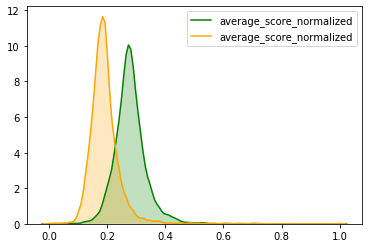

In [18]:
sns.kdeplot(pos_df.average_score_normalized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_normalized, shade=True, color='Orange')
print("Positive Comments (Mean Normalized) : " + str(pos_df.average_score_normalized.mean()))
print("Positive Comments (Std Normalized)  : " + str(pos_df.average_score_normalized.std()))
print("Negative Comments (Mean Normalized) : " + str(neg_df.average_score_normalized.mean()))
print("Negative Comments (Std Normalized)  : " + str(neg_df.average_score_normalized.std()))
print("Difference (Mean Normalized)        : " + str(pos_df.average_score_normalized.mean() - neg_df.average_score_normalized.mean()))
print("Difference (Std Normalized)         : " + str(pos_df.average_score_normalized.std() - neg_df.average_score_normalized.std()))

<br>
The second graph plots the standardized average scores for the positive and negative words. With the data standardized, we can now compare the words across positive and negative DataFrames to determine which words are the most positive, neutral, or negative by frequency and comment score.

Positive Comments (Mean Standardized) : -1.1752844814445877e-15
Positive Comments (Std Standardized)  : 1.0000840159631812
Negative Comments (Mean Standardized) : -7.201027201482756e-16
Negative Comments (Std Standardized)  : 1.0000873782167774
Difference (Mean Standardized)        : -4.551817612963122e-16
Difference (Std Standardized)         : -3.3622535962063438e-06


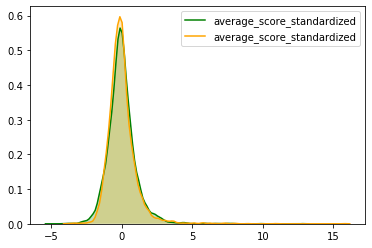

In [19]:
sns.kdeplot(pos_df.average_score_standardized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_standardized, shade=True, color='Orange')
print("Positive Comments (Mean Standardized) : " + str(pos_df.average_score_standardized.mean()))
print("Positive Comments (Std Standardized)  : " + str(pos_df.average_score_standardized.std()))
print("Negative Comments (Mean Standardized) : " + str(neg_df.average_score_standardized.mean()))
print("Negative Comments (Std Standardized)  : " + str(neg_df.average_score_standardized.std()))
print("Difference (Mean Standardized)        : " + str(pos_df.average_score_standardized.mean() - neg_df.average_score_standardized.mean()))
print("Difference (Std Standardized)         : " + str(pos_df.average_score_standardized.std() - neg_df.average_score_standardized.std()))

<br>
This chart shows the top 10 words by average standardized score for positive comments. The distribution skews long tails where the score is many standard deviations above the mean. This can be attributed to the fact that these data sets take a look at the top/lowest 180,000 comments by score out of a dataset that contains 380 million comments. By eliminating the majority of neutrally voted comments by absolute value, some words will be heavily biased due to their low frequency count in relation to their appearance in some highly scored points, whether they be positive or negative. This means that given analysis of enough data points it is highly likely for those top 9 words to fall in the rankings, since the top 9 also comprise entirely out of words that rank below 3700 on their frequency within the corpus.

In [20]:
pos_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4754,shrimp,69,125890,1824.492754,NN,0.000146,0.000882,1.000000,-0.169317,-0.135342,12.836153
4332,gilded,78,124731,1599.115385,VBD,0.000219,0.000871,0.833503,-0.165475,-0.135923,9.867518
5310,thor,59,88902,1506.813559,NN,0.000065,0.000532,0.765316,-0.173586,-0.153893,8.651732
4723,wasps,69,99922,1448.144928,NN,0.000146,0.000636,0.721974,-0.169317,-0.148366,7.878958
4944,pucker,65,93365,1436.384615,NN,0.000113,0.000574,0.713286,-0.171024,-0.151654,7.724053
5232,currency,60,85352,1422.533333,NN,0.000073,0.000498,0.703054,-0.173159,-0.155673,7.541606
5227,bloat,60,84753,1412.550000,NN,0.000073,0.000493,0.695679,-0.173159,-0.155974,7.410107
4657,mold,71,97765,1376.971831,JJ,0.000162,0.000616,0.669395,-0.168463,-0.149448,6.941477
3764,glitter,93,126456,1359.741935,VBP,0.000340,0.000887,0.656667,-0.159073,-0.135058,6.714528
324,gold,1403,1887736,1345.499644,JJ,0.010946,0.017536,0.646146,0.400104,0.748311,6.526930


In [21]:
neg_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4790,diversity,64,-8973,-140.203125,NN,0.000120,0.001293,1.000000,-0.180648,-0.132076,15.769768
2816,inferior,135,-15121,-112.007407,JJ,0.000774,0.002407,0.750928,-0.152134,-0.082336,10.910777
3037,poverty,120,-12046,-100.383333,NN,0.000636,0.001850,0.648245,-0.158158,-0.107214,8.907590
5048,leftist,60,-5763,-96.050000,JJ,0.000083,0.000712,0.609965,-0.182255,-0.158047,8.160824
4832,edit3,63,-5970,-94.761905,JJ,0.000111,0.000749,0.598587,-0.181050,-0.156372,7.938845
96,ha,4617,-436853,-94.618367,VBP,0.042061,0.078825,0.597319,1.647853,3.329675,7.914109
4381,ours,73,-6700,-91.780822,NNS,0.000203,0.000881,0.572253,-0.177034,-0.150466,7.425113
4779,frequent,64,-5847,-91.359375,JJ,0.000120,0.000727,0.568530,-0.180648,-0.157367,7.352484
5508,chuckle,53,-4831,-91.150943,NN,0.000018,0.000543,0.566689,-0.185066,-0.165587,7.316565
4837,stores,63,-5692,-90.349206,NNS,0.000111,0.000699,0.559607,-0.181050,-0.158621,7.178401


<br>
The words from the positive and negative lists are combined to get the standardized score accounting for the difference between the positive commends and negative comments. This segment takes the union of both positive and negative DataFrames and merges the records to find the difference between the average standardized score for each word. The set of words not in the union are then added to the final DataFrame. The negatively standardized data is appropriately modified to reflect the negativity of the words by taking the opposite sign. This is because the standardization was originally representing how negative the word was as  a positive value, but now that we are comparing it to the positivity of the words in the positive word DataFrame, this difference must be reflected in its sign.

In [22]:
inner_join = pd.merge(left=pos_df, right=neg_df, left_on='word',right_on='word')

In [23]:
left = pos_df.loc[np.logical_not(pos_df.word.isin(neg_df.word))]
right = neg_df.loc[np.logical_not(neg_df.word.isin(pos_df.word))]
right[right.select_dtypes(include=[np.number]).columns] *= -1
diff_join = pd.DataFrame(inner_join.word)
diff_join['diff_standardized_score'] = inner_join.average_score_standardized_x - inner_join.average_score_standardized_y
left.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
right.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
diff_df = pd.concat([diff_join, left[["word","diff_standardized_score"]], right[["word","diff_standardized_score"]]])
diff_df.sort_values(by="diff_standardized_score", ascending=False,inplace=True)
diff_df.reset_index(level=0, drop=True, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


<br>
Because we have combined both standardized lists and accounted for the negative words as negative values, the distribution looks similar to the one above. The difference in negative values caused the graph to become mirrored on approxmiately x = 0. This should be expected, since the graphs above were similar to each other, and the DataFrame manipulation only mapped to the difference between the two. This reflects the overall minimal change between both the positive and negative word DataFrames.

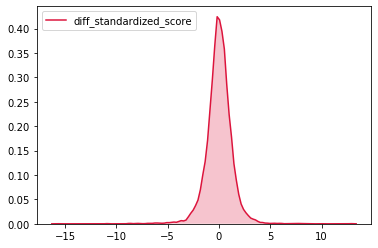

In [24]:
sns.kdeplot(diff_df.diff_standardized_score, shade=True, color='crimson')

<br>This is a list of the top 15 words that predict a positive scoring comment.

In [25]:
diff_df.head(15)

,word,diff_standardized_score
0,shrimp,12.836153
1,gilded,9.867518
2,thor,8.651732
3,currency,8.265685
4,wasps,7.878958
5,pucker,7.724053
6,bloat,7.410107
7,mold,6.941477
8,glitter,6.714528
9,pat,6.053484


<br>This is a list of the top 15 words that predict a negative scoring comment.

In [26]:
diff_df.tail(15)

,word,diff_standardized_score
7034,rpics,-6.250185
7035,stores,-6.475141
7036,gem,-6.649787
7037,frequent,-6.839013
7038,jay,-6.905469
7039,mexicans,-7.053245
7040,iama,-7.563214
7041,ha,-7.845296
7042,edit3,-7.938845
7043,leftist,-8.160824


<br>
This is a list of the 10 words on both sides of standardized 0, which should indicate words that are neutral in predicting the positive or negative score of a comment.

In [27]:
diff_df.loc[3559:3579]

,word,diff_standardized_score
3559,incorrectly,-0.001261
3560,parents,-0.001478
3561,sucked,-0.001481
3562,languages,-0.001936
3563,hyperbole,-0.002108
3564,sherlock,-0.002148
3565,wars,-0.002153
3566,gtthe,-0.002238
3567,disrespect,-0.002874
3568,ruled,-0.002885


<h2><center>Conclusion</center></h2>

The texts for approximately 360,000 comments, 180,000 of which were the most positively scored and 180,000 of which were the most negatively scored comments, were analyzed to explore the relationship between the text of a Reddit post and the score the comment received. The overarching motivation behind this was to test a hypothesis determining the relationship of words and their corresponding positive or negative connotations and seeing if there is a significant correlation between the words used in a Reddit post and the score a Reddit post receives. Rather expectedly, the distrbution of word frequencies skewed heavily towards the left on a distribution plot, indicating that the majority of the words used on Reddit are comprised of a small subset of the entire language. While tidying up the data for word analysis, there were approximately 5.3 million individual words within the text of the 180,000 most positively scored comments alone. The 5.3 million words comprised of approximately 125,000 unique words, with over 80% of the words being cut due to less than 50 unique appearances or for being from a relatively small subset of common words like pronouns, articles or the like. Together with the list compiled for the negative comments, the final list of words came out to around 7,000 unique words. Due to the standaridization, the data set should fit the 68-95-99.7 rule. When looking at the normalized data, the average mean word score for positive words was approximately 28% of the maximum value, while the mean word score for negative words was approximately 19% of the maximum. Both had similar standard deviations of 5.6% and 5.1% of the maxmimum average value. The majority of values fell within the few standard deviations, but due to the relatively sparse nature of the data, a few word became major outliers. One way to curb outliers of this nature are to either expand the scope of the dataset to significantly higher than the 360,000 used in this experiment or to randomly select from the population of comments that exist on reddit to reduce the likelihood of these events.

After coming up with the list of words that comprise the top 15 most positive and negative words, it can be seen that negatively correlated words tended to have a negative connotation in respect to the English language, while the positively correlated words tended to be more random. The 20 most neutral words spanned 10 words from 0 in the distrbution, and these words tended to have a fairly neutral connotation. As a result, it may be possible that words that are highly positively correlated on this list made it to the top due to the small sample size, and the negative words that made it onto the list had their negative score amplified by the small sample size as well. The difference between the connotation of the positive and negative words seemed to be that the positive scores were on average 17 times higher with an average of around 850, while the negative words had an average of approximately -50. The positive comments score positive significantly higher than negative comments scored negative. Even with a low negative mean, the largest standard deviation words eclipsed what is statistically probable, and that is again attributed to the sample size not being able to encompass the dictionary of words as well with only 360,000 non random comments. Analysis of the positivity and negativity of words resulted in list of words that may be able to predict the direction of a comment's score, but the variability of the score's magnitude would not be able to be determined.